In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# load in the dataset and configure pandas and seaborn

sns.set(style = "ticks", color_codes = True, font_scale = 2)
data = pd.read_csv("Davis.csv")
pd.set_option("display.precision", 4)
pd.set_option("display.width", None)

# take a look a the data

data.head()

,Unnamed: 0,sex,weight,height,repwt,repht
0,1,M,77,182,77.0,180.0
1,2,F,58,161,51.0,159.0
2,3,F,53,161,54.0,158.0
3,4,M,68,177,70.0,175.0
4,5,F,59,157,59.0,155.0


In [3]:
# it is clear that the first feature is just an index, we can remove it

data.pop("Unnamed: 0")

0        1
1        2
2        3
3        4
4        5
      ... 
195    196
196    197
197    198
198    199
199    200
Name: Unnamed: 0, Length: 200, dtype: int64

In [4]:
# investigate any NA in the dataset

data.isna().sum().sum()

34

In [5]:
# there are NA, we must remove those rows

data.dropna(inplace=True)

In [6]:
# acquire a summary of the data

data.describe()

,weight,height,repwt,repht
count,181.0000,181.0000,181.0000,181.0000
mean,66.3039,170.1547,65.6796,168.6575
std,15.3410,12.3121,13.8342,9.3947
min,39.0000,57.0000,41.0000,148.0000
25%,56.0000,164.0000,55.0000,161.0000
50%,63.0000,169.0000,63.0000,168.0000
75%,75.0000,178.0000,74.0000,175.0000
max,166.0000,197.0000,124.0000,200.0000


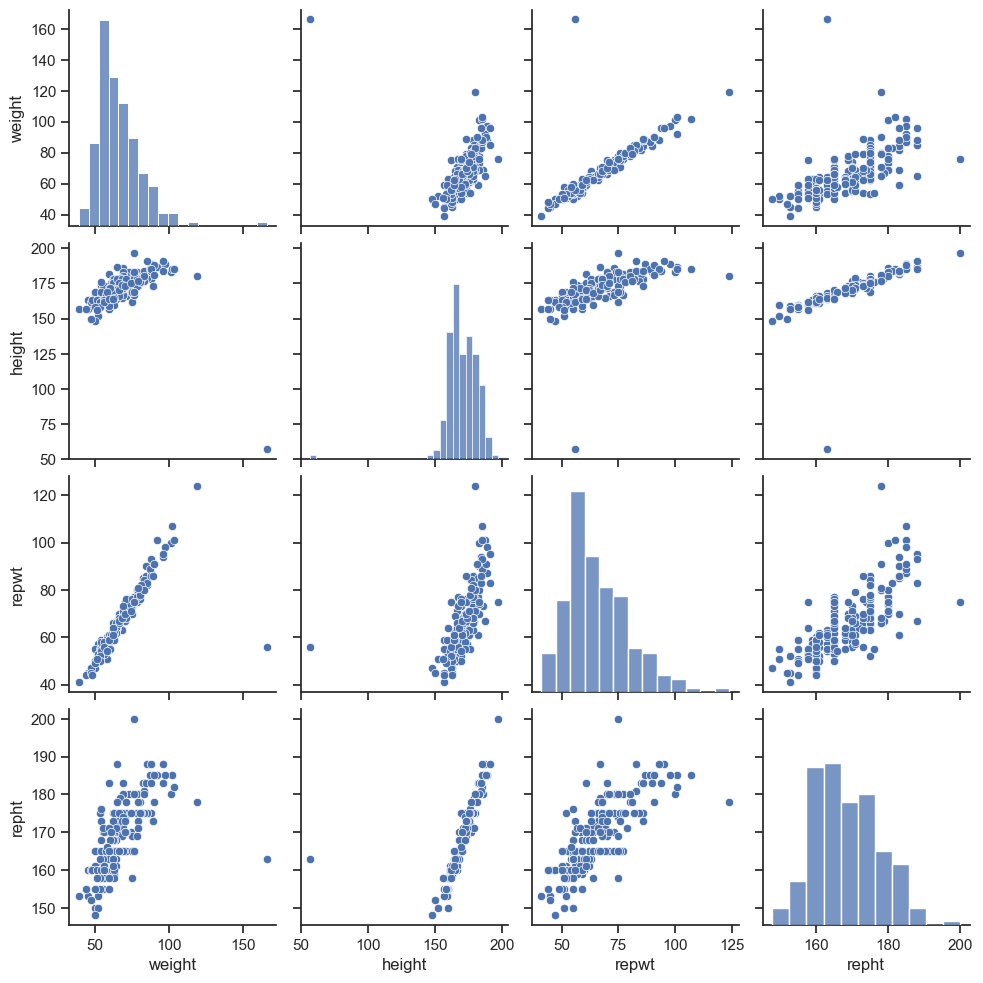

<Figure size 400x300 with 0 Axes>

In [7]:
# visual summary of data

sns.set(style = "ticks", color_codes = True)
graph = sns.pairplot(data)
plt.figure(figsize=(4,3))
plt.show()

In [8]:
# There is an outlier seen on most of the graphs - a very low height. let us check this row

data[data["height"] == data["height"].min()]

,sex,weight,height,repwt,repht
11,F,166,57,56.0,163.0


In [9]:
# It appears based on the repwt and repht that this is a data entry error at entry 11 where actual height and weight have been swapped. Let us fix this

temp = data.at[11, "height"]
data.at[11, "height"] = data.at[11, "weight"]
data.at[11, "weight"] = temp

data.iloc[11]

sex           F
weight       57
height      166
repwt      56.0
repht     163.0
Name: 11, dtype: object

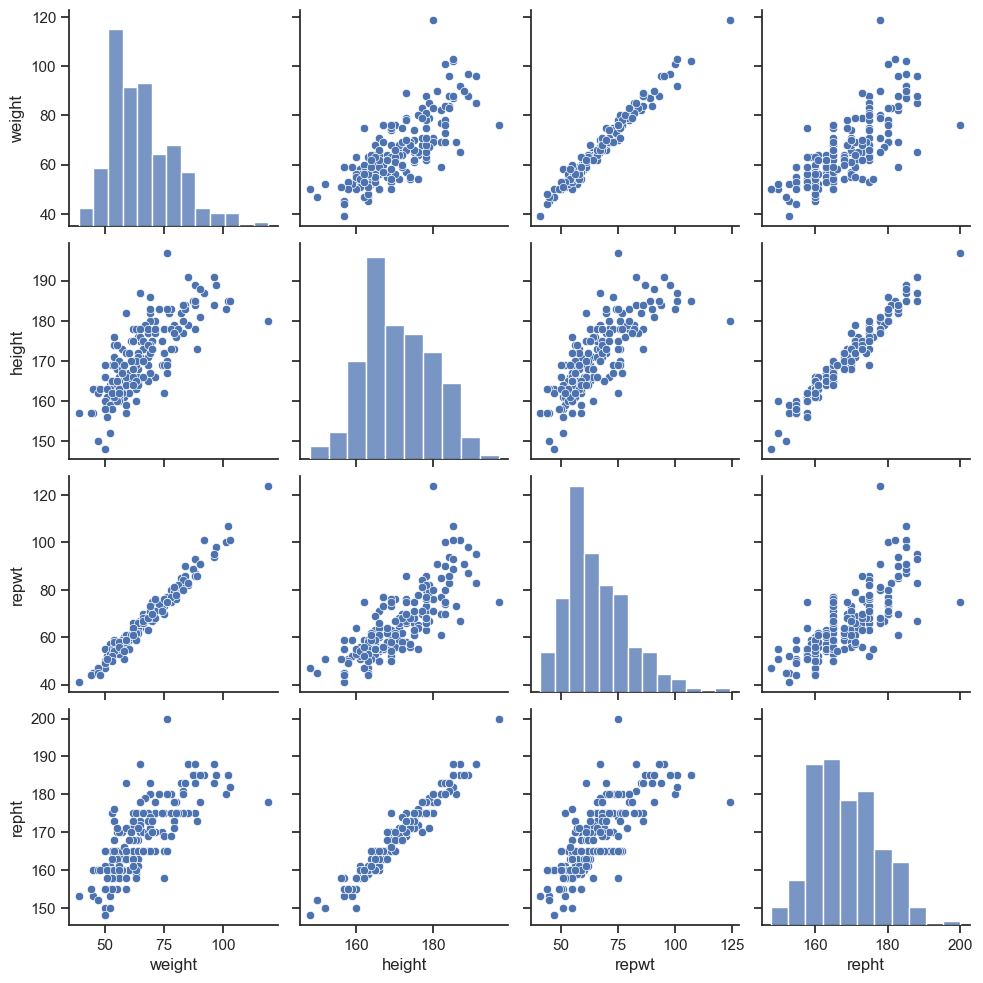

<Figure size 400x300 with 0 Axes>

In [10]:
# look at the data with the outlier fixed

graph = sns.pairplot(data)
plt.figure(figsize=(4,3))
plt.show()

In [11]:
# We see some potential linear relationships, and based on the histograms the data looks normal
# We need to transform the categorical variable of sex before we train our regression model

data2 = pd.get_dummies(data)
data2.head()

,weight,height,repwt,repht,sex_F,sex_M
0,77,182,77.0,180.0,False,True
1,58,161,51.0,159.0,True,False
2,53,161,54.0,158.0,True,False
3,68,177,70.0,175.0,False,True
4,59,157,59.0,155.0,True,False


In [12]:
# check correlation coefficients of data

data2.corr()

,weight,height,repwt,repht,sex_F,sex_M
weight,1.0000,0.7685,0.9861,0.7487,-0.6984,0.6984
height,0.7685,1.0000,0.7828,0.9756,-0.7394,0.7394
repwt,0.9861,0.7828,1.0000,0.7619,-0.7178,0.7178
repht,0.7487,0.9756,0.7619,1.0000,-0.7382,0.7382
sex_F,-0.6984,-0.7394,-0.7178,-0.7382,1.0000,-1.0000
sex_M,0.6984,0.7394,0.7178,0.7382,-1.0000,1.0000


In [13]:
# split the data into testing and training data
# We will also remove repht from the data as it seems to be colinear with height (as expected)

from sklearn.model_selection import train_test_split

X_data = data2.copy()
X_data.pop("weight")
X_data.pop("repht")
X_data.pop("sex_F")

X_train, X_test, y_train, y_test = train_test_split(X_data, data["weight"], test_size=0.2, random_state=10)

In [14]:
# Create a new linear regression model and train with our data

from sklearn.linear_model import LinearRegression

lin_regression = LinearRegression()

lin_regression.fit(X=X_train, y=y_train)

LinearRegression()

In [15]:
# find the model coefficients for each feature

for i, name in enumerate(X_data.columns):
    print(f"{name:>10}: {lin_regression.coef_[i]}")

    height: 0.018280681964792333
     repwt: 0.9715869063568741
     sex_M: -0.39495892057501925


In [16]:
# find the model intercept for each feature

lin_regression.intercept_

-1.0829710025336396

In [17]:
# create arrays containing the expected weights from the test set vs the predicted weights

predicted = lin_regression.predict(X_test)

expected = y_test

In [18]:
# peek at the predicted values

predicted[:5]

array([67.73425701, 55.22437592, 57.27723382, 90.24528199, 64.02350012])

In [19]:
# peek at the expected values

expected = expected.reset_index()
expected = expected["weight"]
expected[:5]

0    69
1    59
2    56
3    90
4    63
Name: weight, dtype: int64

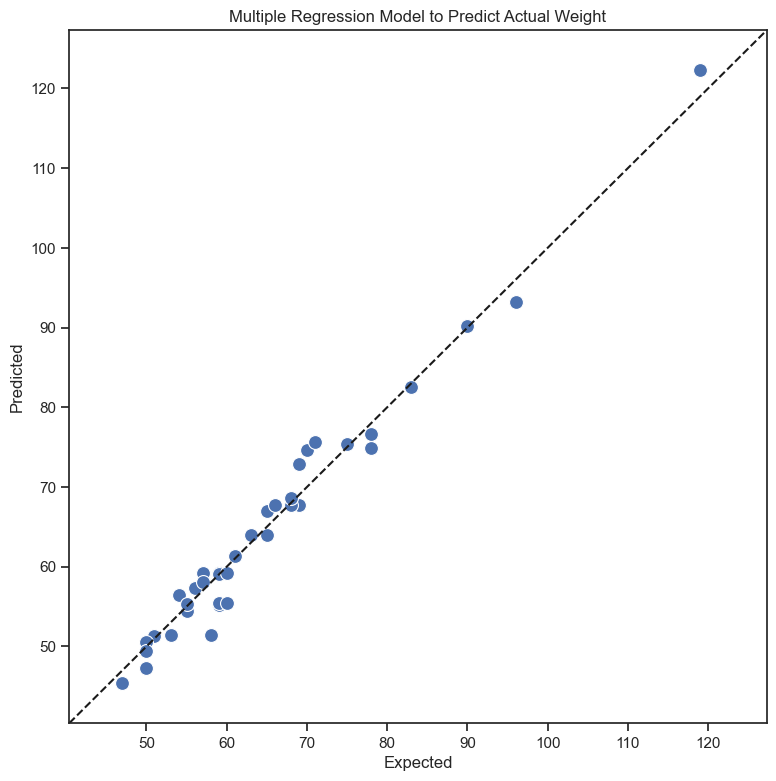

In [20]:
# visualize the difference between the predicted and expected values for weight

comparison = pd.DataFrame()
comparison["Expected"] = pd.Series(expected)
comparison["Predicted"] = pd.Series(predicted)
figure = plt.figure(figsize=(9,9))
axes = sns.scatterplot(data=comparison, x="Expected", y="Predicted", legend=False, s=100)
axes.grid(False)
start = min(expected.min(), predicted.min()) - 5
end = max(expected.max(), predicted.max()) + 5
axes.set_xlim(start, end)
axes.set_ylim(start, end)
axes.set_title("Multiple Regression Model to Predict Actual Weight")
line = plt.plot([start,end], [start, end], "k--")
plt.show()

In [21]:
# Calculate quality of fit statistics

from sklearn import metrics

print("Coefficient of Determination:", metrics.r2_score(expected, predicted))
print("Mean Squared Error:", metrics.mean_squared_error(expected, predicted))
print("Correlation Coefficient:", comparison.corr().iloc[0]["Predicted"])

Coefficient of Determination: 0.9707513446273938
Mean Squared Error: 5.9350200681278436
Correlation Coefficient: 0.9869954074102819


In [22]:
# compare to simple linear regression - reported weight

X_train_repwt, X_test_repwt, y_train_repwt, y_test_repwt = train_test_split(data["repwt"], data["weight"], test_size=0.2, random_state=10)

X_train_repwt = np.reshape(X_train_repwt, (-1,1))
X_test_repwt = np.reshape(X_test_repwt, (-1,1))

lin_regression_repwt = LinearRegression()
lin_regression_repwt.fit(X=X_train_repwt, y=y_train_repwt)

print("reported weight coefficient:", lin_regression_repwt.coef_[0])
print("reported weight intercept:", lin_regression_repwt.intercept_)

reported weight coefficient: 0.9704548571033698
reported weight intercept: 1.9401625422848667


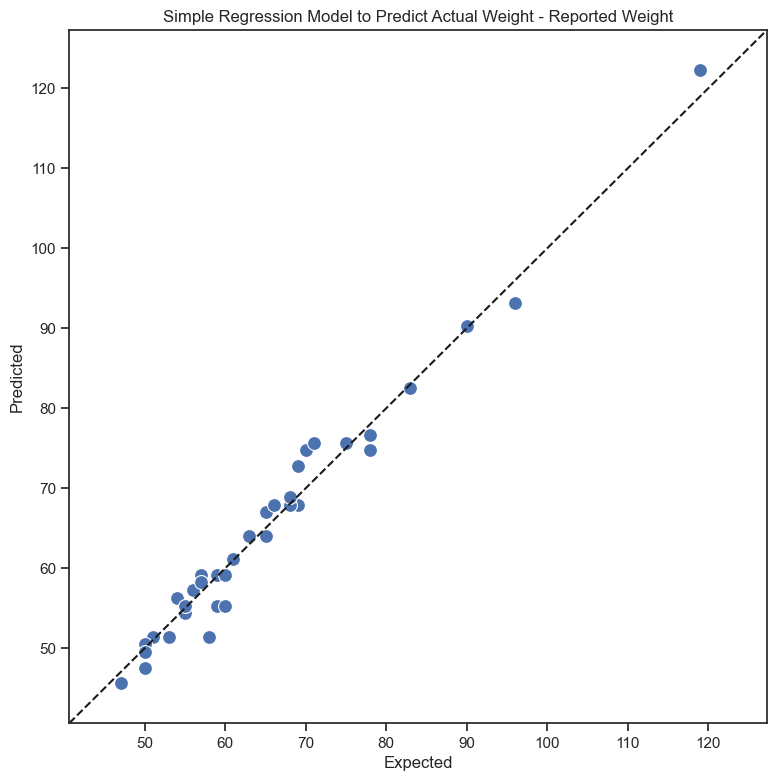

In [50]:
# plot simple regression results - reported weight

predicted_repwt = lin_regression_repwt.predict(X_test_repwt)
expected_repwt = y_test_repwt
expected_repwt = expected_repwt.reset_index()
expected_repwt = expected_repwt["weight"]

comparison_repwt = pd.DataFrame()
comparison_repwt["Expected"] = pd.Series(expected_repwt)
comparison_repwt["Predicted"] = pd.Series(predicted_repwt)
figure = plt.figure(figsize=(9,9))
axes = sns.scatterplot(data=comparison_repwt, x="Expected", y="Predicted", legend=False, s=100)
start = min(expected_repwt.min(), predicted_repwt.min()) - 5
end = max(expected_repwt.max(), predicted_repwt.max()) + 5
axes.set_xlim(start, end)
axes.set_ylim(start, end)
axes.set_title("Simple Regression Model to Predict Actual Weight - Reported Weight")
line = plt.plot([start,end], [start, end], "k--")

In [24]:
# Calculate quality of fit statistics - reported weight

print("Coefficient of Determination:", metrics.r2_score(expected_repwt, predicted_repwt))
print("Mean Squared Error:", metrics.mean_squared_error(expected_repwt, predicted_repwt))
print("Correlation Coefficient:", comparison_repwt.corr().iloc[0]["Predicted"])

Coefficient of Determination: 0.9706997358617252
Mean Squared Error: 5.945492312271458
Correlation Coefficient: 0.9869187224536047


In [25]:
# compare to simple linear regression - reported height

X_train_repht, X_test_repht, y_train_repht, y_test_repht = train_test_split(data["repht"], data["weight"], test_size=0.2, random_state=10)

X_train_repht = np.reshape(X_train_repht, (-1,1))
X_test_repht = np.reshape(X_test_repht, (-1,1))

lin_regression_repht = LinearRegression()
lin_regression_repht.fit(X=X_train_repht, y=y_train_repht)

print("reported height coefficient:", lin_regression_repht.coef_[0])
print("reported height intercept:", lin_regression_repht.intercept_)

reported height coefficient: 1.0850618268847234
reported height intercept: -117.570037229092


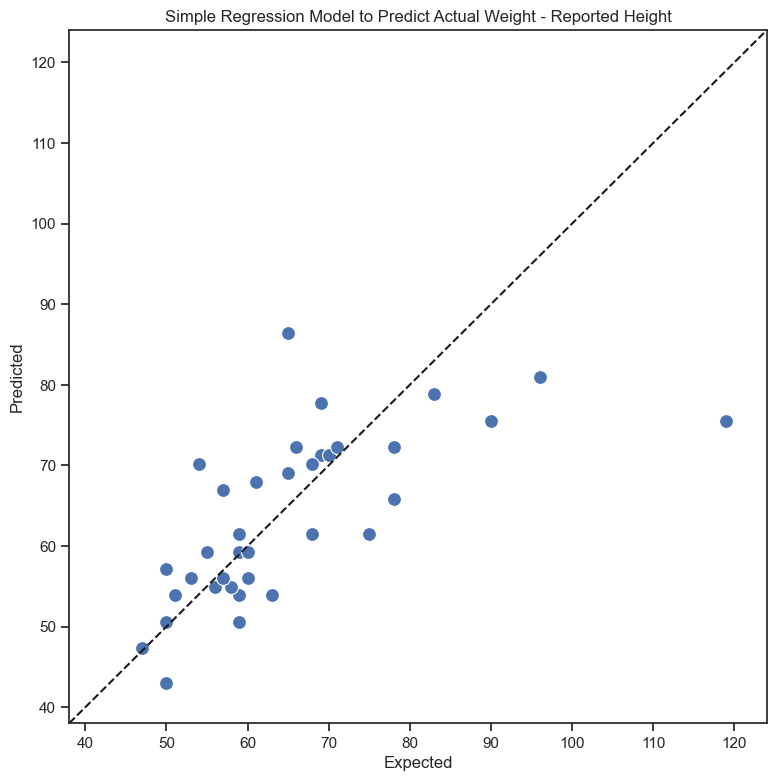

In [48]:
# plot simple regression results - reported height

predicted_repht = lin_regression_repht.predict(X_test_repht)
expected_repht = y_test_repht
expected_repht = expected_repht.reset_index()
expected_repht = expected_repht["weight"]

comparison_repht = pd.DataFrame()
comparison_repht["Expected"] = pd.Series(expected_repht)
comparison_repht["Predicted"] = pd.Series(predicted_repht)
figure = plt.figure(figsize=(9,9))
axes = sns.scatterplot(data=comparison_repht, x="Expected", y="Predicted", legend=False, s=100)
start = min(expected_repht.min(), predicted_repht.min()) - 5
end = max(expected_repht.max(), predicted_repht.max()) + 5
axes.set_xlim(start, end)
axes.set_ylim(start, end)
axes.set_title("Simple Regression Model to Predict Actual Weight - Reported Height")
line = plt.plot([start,end], [start, end], "k--")

In [27]:
# Calculate quality of fit statistics - reported height

print("Coefficient of Determination:", metrics.r2_score(expected_repht, predicted_repht))
print("Mean Squared Error:", metrics.mean_squared_error(expected_repht, predicted_repht))
print("Correlation Coefficient:", comparison_repht.corr().iloc[0]["Predicted"])

Coefficient of Determination: 0.4507932900539131
Mean Squared Error: 111.44282715072562
Correlation Coefficient: 0.6784686898757926


In [28]:
# compare to simple linear regression - actual height

X_train_height, X_test_height, y_train_height, y_test_height = train_test_split(data["height"], data["weight"], test_size=0.2, random_state=10)

X_train_height = np.reshape(X_train_height, (-1,1))
X_test_height = np.reshape(X_test_height, (-1,1))

lin_regression_height = LinearRegression()
lin_regression_height.fit(X=X_train_height, y=y_train_height)

print("actual height coefficient:", lin_regression_height.coef_[0])
print("actual height intercept:", lin_regression_height.intercept_)

actual height coefficient: 1.2138583349624954
actual height intercept: -141.90996995482942


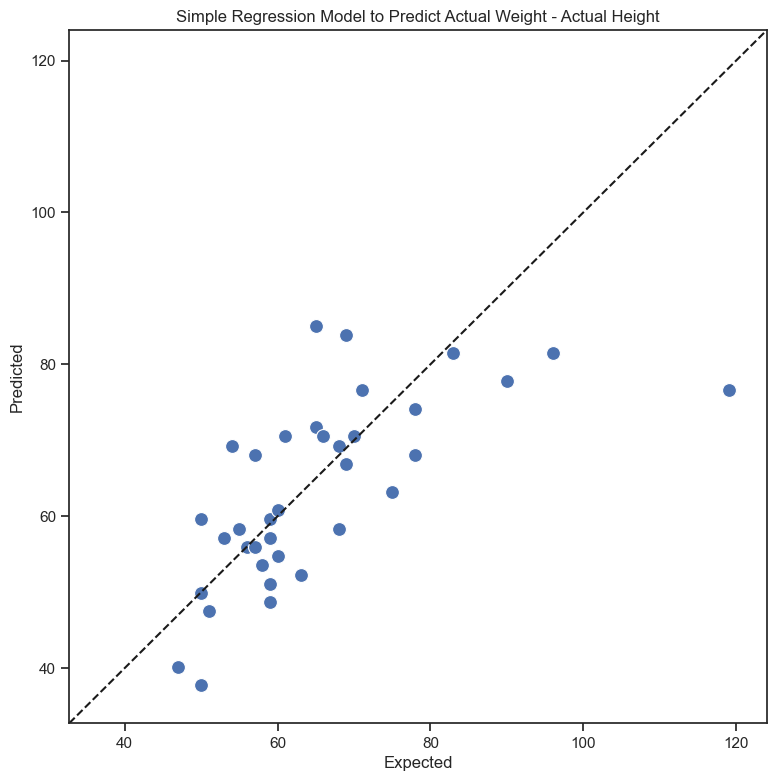

In [49]:
# plot simple regression results - actual height

predicted_height = lin_regression_height.predict(X_test_height)
expected_height = y_test_height
expected_height = expected_height.reset_index()
expected_height = expected_height["weight"]

comparison_height = pd.DataFrame()
comparison_height["Expected"] = pd.Series(expected_height)
comparison_height["Predicted"] = pd.Series(predicted_height)
figure = plt.figure(figsize=(9,9))
axes = sns.scatterplot(data=comparison_height, x="Expected", y="Predicted", legend=False, s=100)
start = min(expected_height.min(), predicted_height.min()) - 5
end = max(expected_height.max(), predicted_height.max()) + 5
axes.set_xlim(start, end)
axes.set_ylim(start, end)
axes.set_title("Simple Regression Model to Predict Actual Weight - Actual Height")
line = plt.plot([start,end], [start, end], "k--")

In [30]:
# Calculate quality of fit statistics - actual height

print("Coefficient of Determination:", metrics.r2_score(expected_height, predicted_height))
print("Mean Squared Error:", metrics.mean_squared_error(expected_height, predicted_height))
print("Correlation Coefficient:", comparison_height.corr().iloc[0]["Predicted"])

Coefficient of Determination: 0.4192357294546065
Mean Squared Error: 117.84636102508834
Correlation Coefficient: 0.6753895007106477


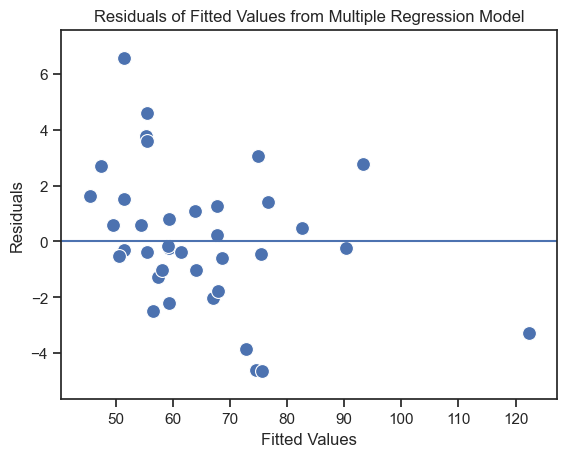

In [42]:
# asses Homoscedasticity

residuals = comparison.copy()
for i in range(len(residuals)):
    residuals.at[i, "Expected"] -= residuals.at[i, "Predicted"]

axes = sns.scatterplot(data=residuals, x="Predicted", y="Expected", legend=False, s=100)
axes.set_xlim(min(residuals["Predicted"]) - 5, max(residuals["Predicted"]) + 5)
axes.set_ylim(min(residuals["Expected"]) - 1, max(residuals["Expected"]) + 1)
axes.set_title("Residuals of Fitted Values from Multiple Regression Model")
axes.set_ylabel("Residuals")
axes.set_xlabel("Fitted Values")
axes.axhline(y=0)
plt.show()

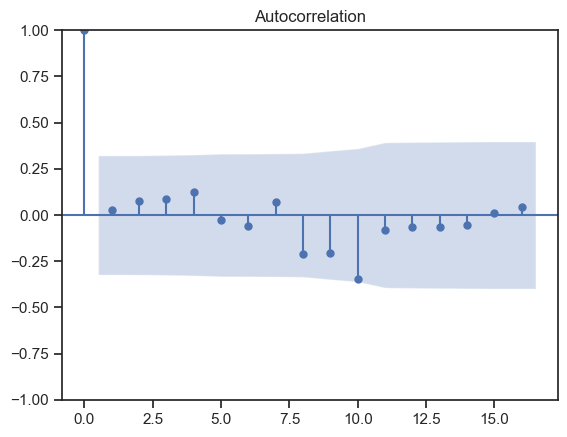

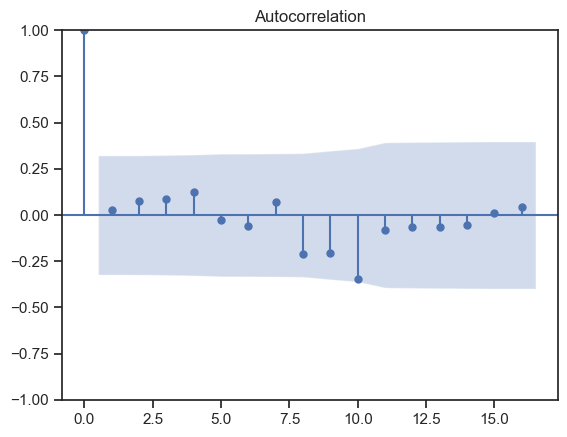

In [43]:
# No autocorrelation of variables

import statsmodels.graphics.tsaplots as smg

smg.plot_acf(residuals["Expected"])

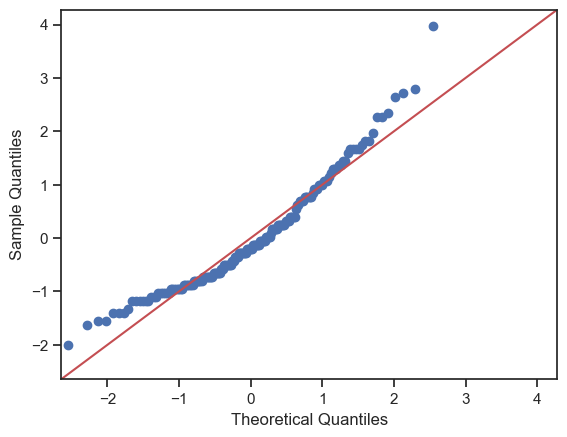

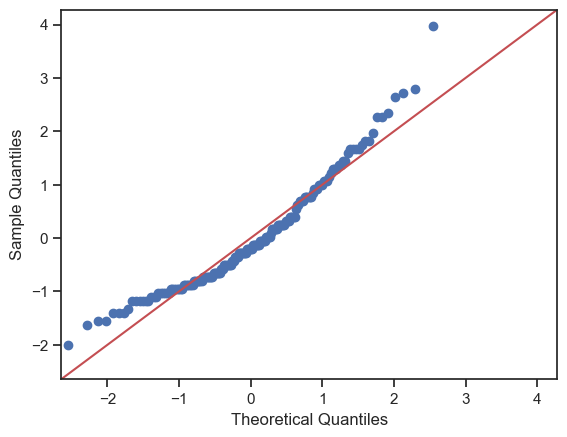

In [44]:
# Normality of Data (QQ Plot)

import statsmodels.api as sm

sm.qqplot(data2["weight"], line="45", fit=True)

In [45]:
# Shapiro Wilk Test on weight data

from scipy.stats import shapiro

shapiro(data2["weight"])

ShapiroResult(statistic=0.9441988468170166, pvalue=1.6363759414161905e-06)

In [46]:
# Shapiro Wilk Test on Residuals

shapiro(residuals["Expected"])

ShapiroResult(statistic=0.979602575302124, pvalue=0.7177702784538269)

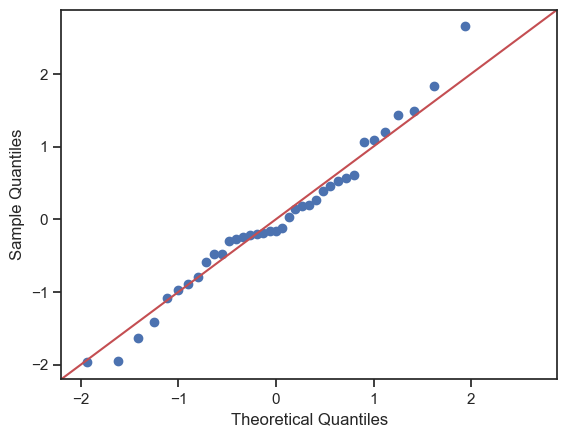

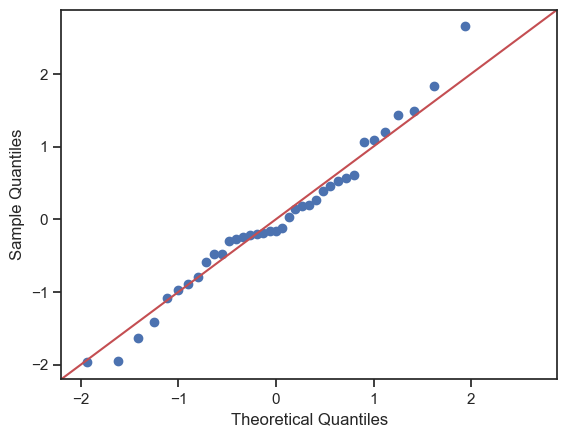

In [47]:
# QQ plot of residuals

sm.qqplot(residuals["Expected"], line="45", fit=True)